In [15]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch
import numpy as np
from scipy.spatial import ConvexHull
from scipy import stats
import seaborn as sns
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import warnings
from matplotlib.colors import LinearSegmentedColormap

#Read in the data
df = pd.read_csv('Footballdata/New/ManUtdvsWolves.csv', encoding='latin-1', low_memory = False)

#df = df.loc[df['period/displayName'] == 'SecondHalf']
#8. ArsenalvsSpurs
#Adjust for pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#Combo box, choose players
options = df["name"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Bruno Fernandes', 'Casemiro', 'Luke Sh…

In [16]:
#df = df.loc[df['period/displayName'] == 'FirstHalf']

#remove
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Finding previous event to filter out setpieces
df['prevevent'] = df['type_displayName'].shift(1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'CornerAwarded'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'OffsideGiven'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'SubstitutionOn'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'FormationChange'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Start'))]

#Take out corners and throw ins
#df = df.loc[(df['x'] < 119.39)]
df = df.loc[(df['y'] > 0)]
df = df.loc[(df['y'] < 80)]

#Filter for data (df1 is inclusive of all data of a particular player)
player = playerlist.value
Touch = df.loc[df['name']== player].reset_index()

#If need to highlight goals
#Goal = df.loc[(df['playername']== player) & (df['type_displayName']== "Goal")].reset_index()

#Filter for successful touches and take it's x and y value
Touch = Touch[Touch['isTouch'] == True]

#Retrieve team name from the passes
team = Touch['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

Touch = Touch[['name','shirtNo','x', 'y']]

#Find median
MedianTouch = Touch.groupby('shirtNo').agg({'x': ['median'], 'y': ['median']})

#use astype to convert to int
MedianTouch.index = MedianTouch.index.astype(int)

#filter that dataframe to exclude outliers. Anything over a z score of 1 will be excluded for the data points
df1 = Touch[(np.abs(stats.zscore(Touch[['x','y']])) < 0.75)]
df1 = df1[['x', 'y']]
df1 = df1.dropna()

#Create an array of the x/y coordinate groups
points = df1[['x', 'y']].values

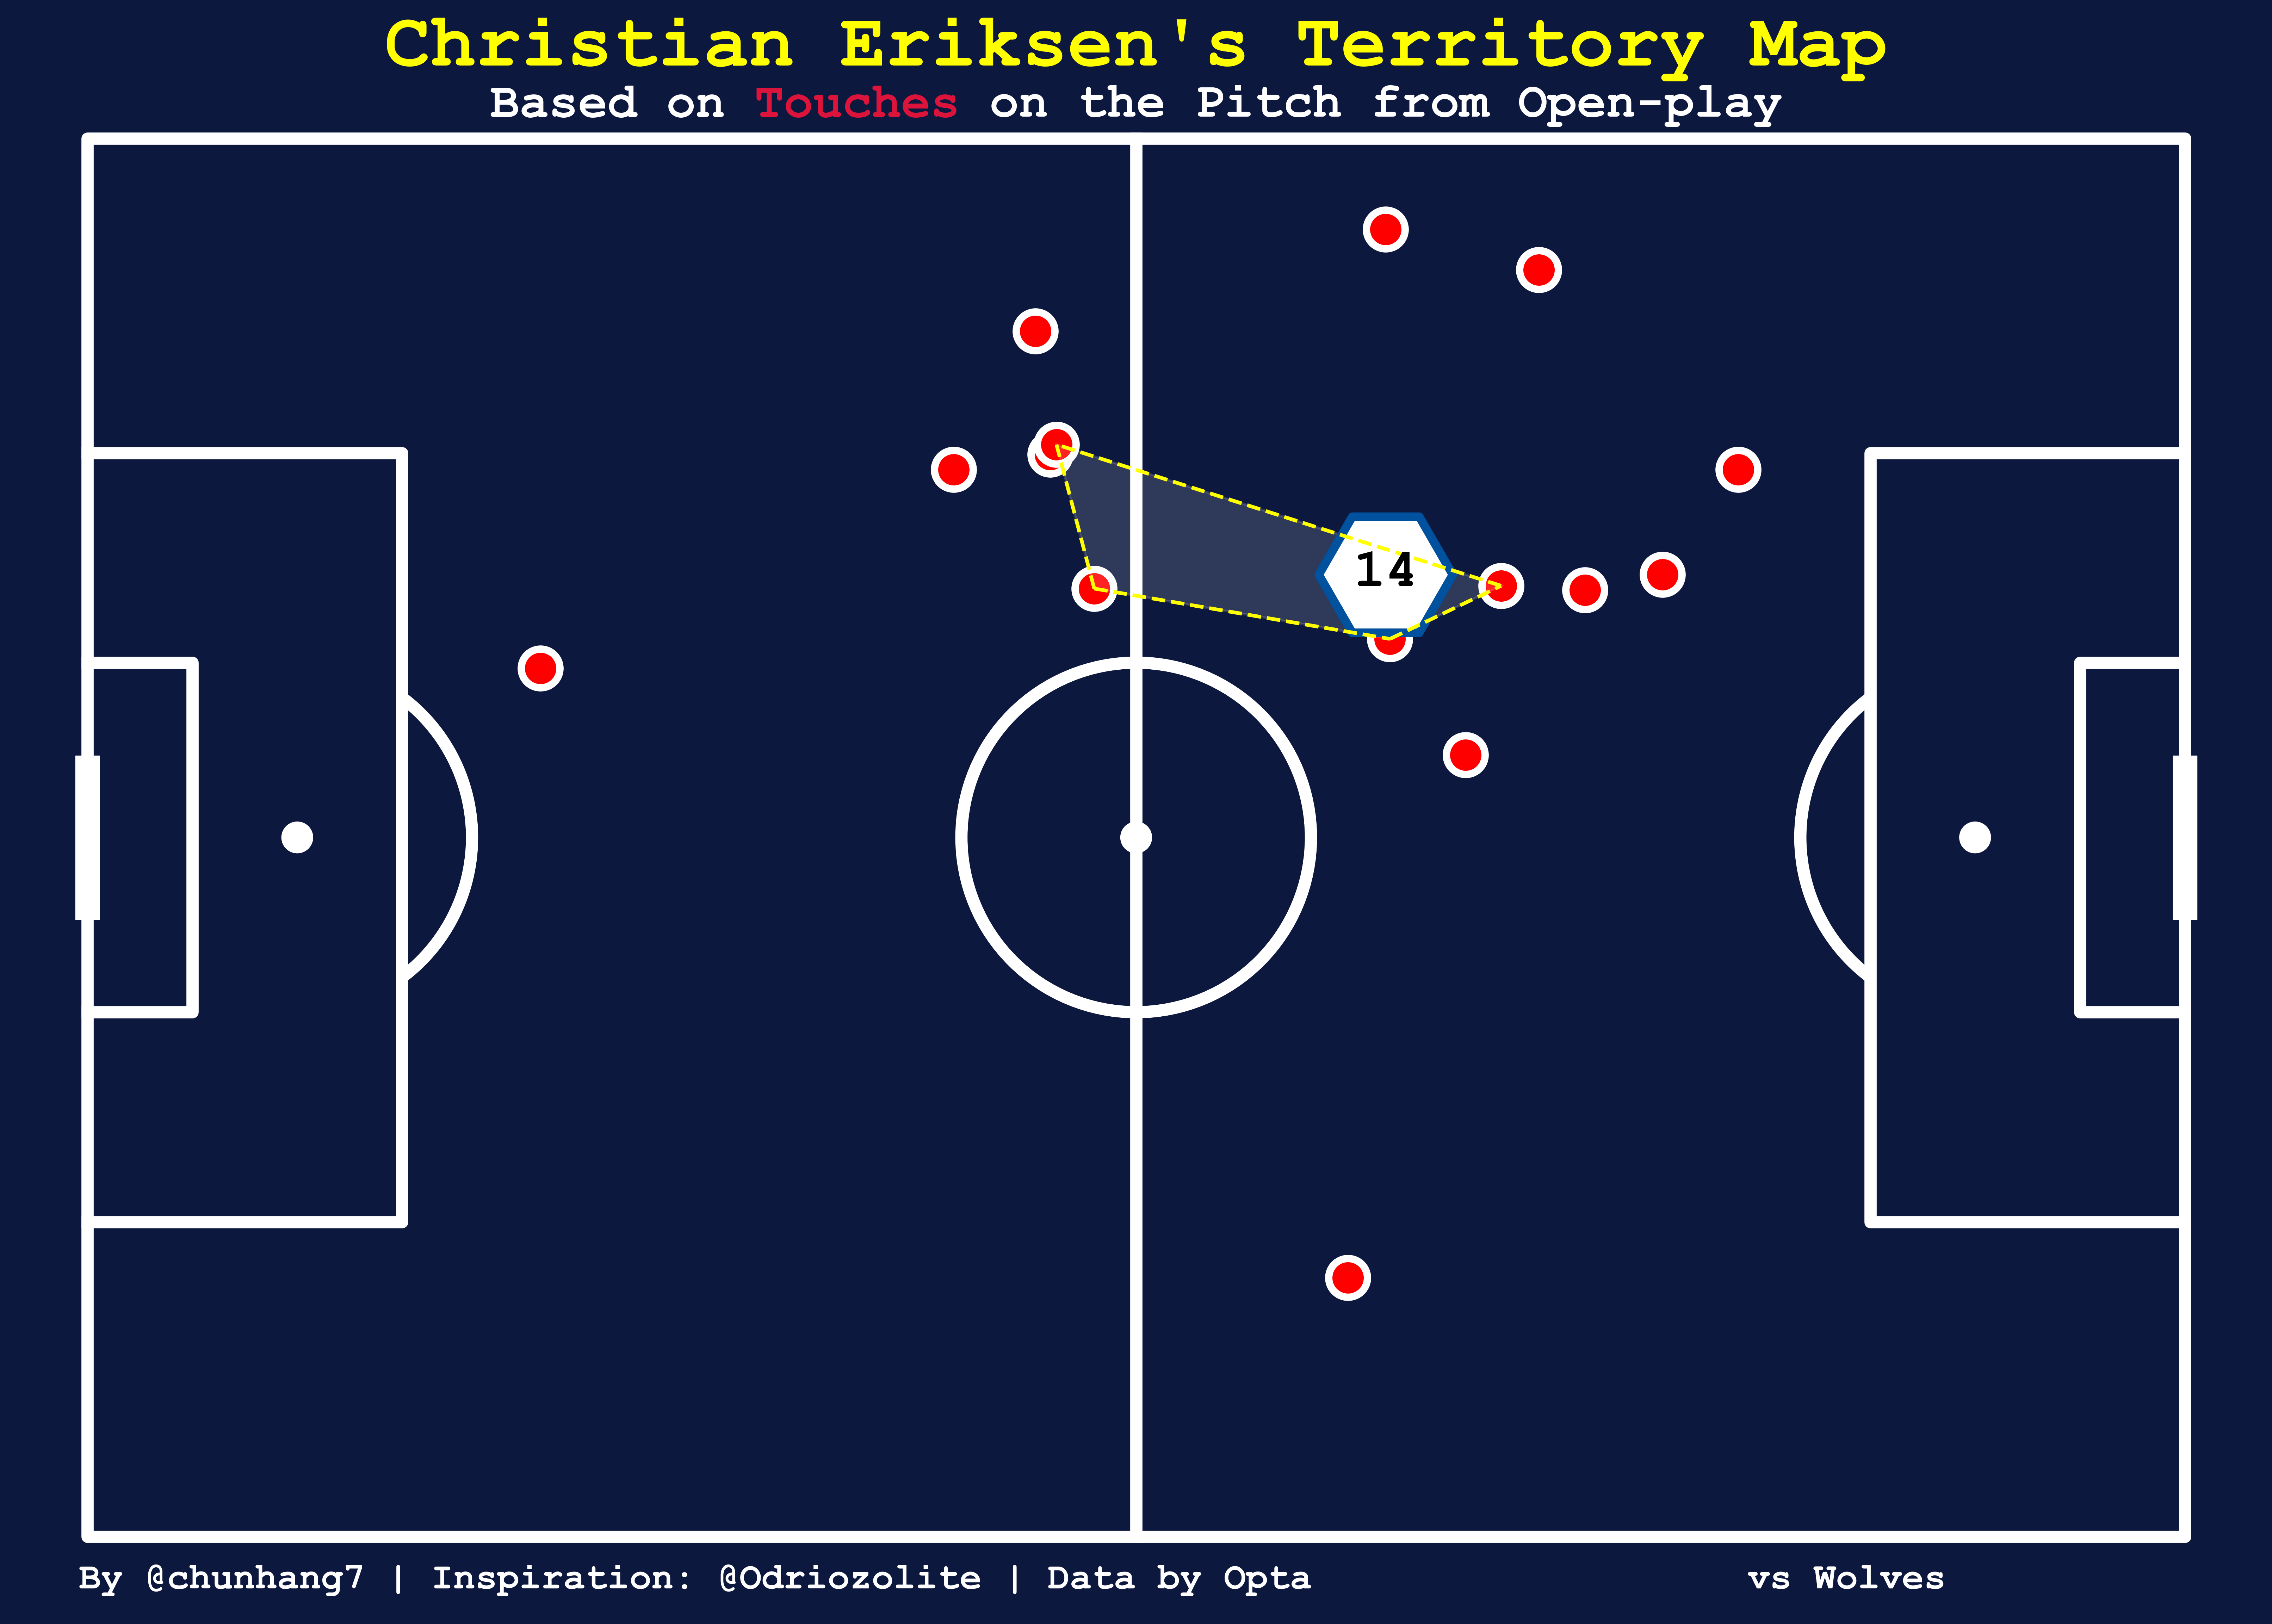

In [17]:
#Set up pitch
pitch = Pitch(pitch_type='statsbomb',linewidth=5, spot_scale=0.007,
             pitch_color='#0d183f',line_color='w')
fig,ax = pitch.draw(figsize=(13, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse the y-axis
plt.gca().invert_yaxis()

#plot the pass locations
plt.scatter(Touch.x, Touch.y, marker='o', s=250, c='red',
            linewidth = 3, edgecolor='w')

#Create the convex hull
hull = ConvexHull(df1[['x','y']])

#Loop through each of the hull's simplices
for i in hull.simplices:
    plt.plot(points[i, 0], points[i, 1], 'yellow', ls ='--')
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c='white', alpha=0.04)

#plot the Median location
plt.scatter(MedianTouch.x, MedianTouch.y, marker='H', s=3000, c='w', 
            linewidth = 3.5, edgecolor='#00529F')

#Kit Numbers on Nodes
for index, row in MedianTouch.iterrows():
    pitch.annotate(row.name, xy=(row.x,row.y), c='black', va='center', ha='center', 
                   size=22, fontweight='bold', fontfamily="Courier New",ax=ax)

#Title & Annotations
fig.suptitle(player +"'s Territory Map", fontsize=31, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.9)

highlight_textprops =\
    [{"color": "crimson","fontweight": 'bold'}]

Title = fig_text(s = "Based on <Touches> on the Pitch from Open-play" ,
        x = 0.5, y = 0.865, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=20);

#Credits
ax.text(-0.5, -2.5, 'By @chunhang7 | Inspiration: @Odriozolite | Data by Opta', va='center', ha='left', 
        fontfamily = "Courier New", fontsize=15, 
        color='w',fontweight='bold')

ax.text(95, -2.5, 'vs '+ oppo, va='center', ha='left', fontsize=15, color='w',
        fontweight = "bold", fontfamily = "Courier New")

plt.show()

# Vertical Pitch

In [4]:
#Set up pitch
mpl.rcParams['figure.dpi'] = 500
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Plot points
pitch.scatter(Touch.x, Touch.y, marker='o', s=1200, c='#FFDF00', linewidth = 4, 
              ax=ax, edgecolor='crimson', alpha=0.85)

#Plot points
pitch.scatter(Touch.x, Touch.y, marker='o', s=700, c='crimson', linewidth = 4, 
              ax=ax, edgecolor='#FFDF00')

#Goals
#pitch.scatter(Goal.x, Goal.y, marker='o', s=1200, c='#00c631', linewidth = 5, ax=ax, edgecolor='yellow')

#Create the convex hull
hull = ConvexHull(df1[['x','y']])

#Loop through each of the hull's simplices
for i in hull.simplices:
    plt.plot(points[i, 1], points[i, 0], 'yellow', ls ='--', lw=5)
    plt.fill(points[hull.vertices,1], points[hull.vertices,0], c='white', alpha=0.1)
    
#plot the Median location
pitch.scatter(MedianTouch.x, MedianTouch.y, marker='H', s=4000, c='w', ax=ax,
            linewidth = 5, edgecolor='#004D98')

#Kit Numbers on Nodes
for index, row in MedianTouch.iterrows():
    pitch.annotate(row.name, xy=(row.x,row.y), c='black', va='center', ha='center', 
                   size=30, fontweight='bold', fontfamily="Courier New",ax=ax)

#Title & Annotations
fig.suptitle("\n\nAlexander-Arnold's Touch Map\n\n", fontsize=45, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.96)

highlight_textprops =\
    [{"color": "yellow","fontweight": 'bold'}]

Title = fig_text(s = "vs <Athletic Bilbao> | Premier League 2022/23" ,
        x = 0.5, y = 0.86, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=27);

#Space
ax.text(95, -3, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(-8, -3, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

# Heatmap

In [5]:
#ignore warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Set Color
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#000000','#67000d','#db2824','#fd5901','yellow'])

pitch = VerticalPitch(pitch_type='opta', pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

kde = pitch.kdeplot(Touch.x, Touch.y, statistic='count', ax=ax, cmap=customcmap, shade=True, 
                    shade_lowest=False, n_levels=400, linewidths=3, alpha=1, zorder=0.99)

#Title & Annotations
fig.suptitle("\n"+player+"'s Heatmap\nArgentina | Fifa World Cup 2022", fontsize=40, color='yellow',
            fontfamily = "Courier New", fontweight = "bold", y=0.98)

ax.text(112, -2.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(-2, -2.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

AttributeError: PolyCollection.set() got an unexpected keyword argument 'statistic'